# Import Packages

In [1]:
import random
import math
import re
import time
import os
import sys
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2

# Import Mask RCNN
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

from samples.lego import lego

ROOT_DIR = './'

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

tf.__version__

2021-09-19 22:40:29.950872: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


'2.5.0'

# Infer RPN

### Load Configuration

In [2]:
# LEGO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "snapshots", "mask_rcnn_lego_0041.h5") # Comment out to use snapshot from latest training
LEGO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "snapshots", "lego20210912T0137", "mask_rcnn_lego_0040.h5") # Comment out to use snapshot from latest training
# LEGO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "snapshots", "lego20210912T1007","mask_rcnn_lego_0040.h5") # Comment out to use snapshot from latest training

DATASET = "eval"
config = lego.LegoConfig()
LEGO_DIR = os.path.join(ROOT_DIR, "datasets", "lego")

class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1


config = InferenceConfig()
config.display()

def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax


Configurations:
BACKBONE                       resnet101
BACKBONE_FITLERS_CONFIG        {'S2': [64, 64], 'S3': [128, 128], 'S4': [256, 256], 'S5': [512, 512]}
BACKBONE_MRCNN                 resnet18
BACKBONE_RESNET_BASIC_DEFAULT  {'S2': [64, 64], 'S3': [128, 128], 'S4': [256, 256], 'S5': [512, 512]}
BACKBONE_RESNET_BASIC_WIDER    {'S2': [160, 160], 'S3': [320, 320], 'S4': [640, 640], 'S5': [1280, 1280]}
BACKBONE_RESNET_BOTTLE_DEFAULT {'S2': [64, 64, 256], 'S3': [128, 128, 512], 'S4': [256, 256, 1024], 'S5': [512, 512, 2048]}
BACKBONE_RESNET_BOTTLE_WIDER   {'S2': [256, 256, 256], 'S3': [512, 512, 512], 'S4': [1024, 1024, 1024], 'S5': [1024, 1024, 2048]}
BACKBONE_RPN                   resnet18
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZ

### Load Dataset

In [3]:
# dataset = lego.LegoDataset()
# dataset.load_lego(LEGO_DIR, DATASET)
# dataset.prepare()
# print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

### Load Model and Weights

In [4]:
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)
print("Loading weights ", LEGO_WEIGHTS_PATH)
model.load_weights(LEGO_WEIGHTS_PATH, by_name=True)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Instructions for updating:
Use fn_output_signature instead


2021-09-19 22:40:35.137651: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-09-19 22:40:35.195157: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:41:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2021-09-19 22:40:35.195187: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-09-19 22:40:35.198204: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-09-19 22:40:35.198247: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2021-09-19 22:40:35.198945: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.

Loading weights  ./snapshots/lego20210912T0137/mask_rcnn_lego_0040.h5


2021-09-19 22:40:36.324428: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-09-19 22:40:36.326177: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:41:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2021-09-19 22:40:36.327239: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible gpu devices: 0
2021-09-19 22:40:36.327282: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-09-19 22:40:36.737072: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect Stream

Re-starting from epoch 40


# Run Evaluation

In [5]:
test_images_path = os.path.join('datasets', 'lego', 'eval')
test_images = [file for file in os.listdir(test_images_path) if file.endswith('.png')]

/home/panda/.conda/envs/lego/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
2021-09-19 22:40:40.948761: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2021-09-19 22:40:41.305155: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8200
2021-09-19 22:40:41.753990: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-09-19 22:40:42.155311: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


<Figure size 432x288 with 0 Axes>

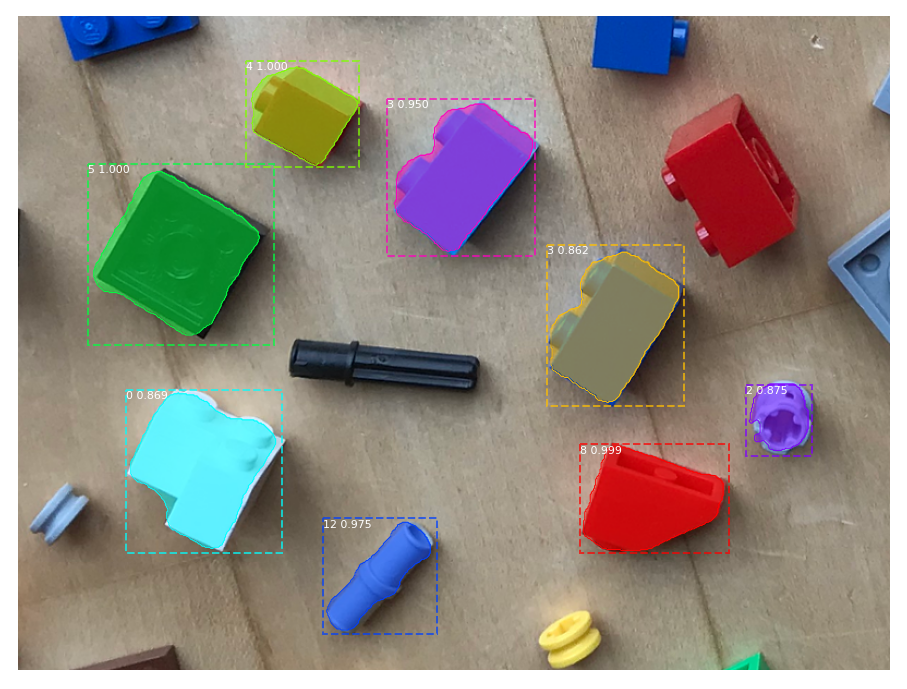

<Figure size 432x288 with 0 Axes>

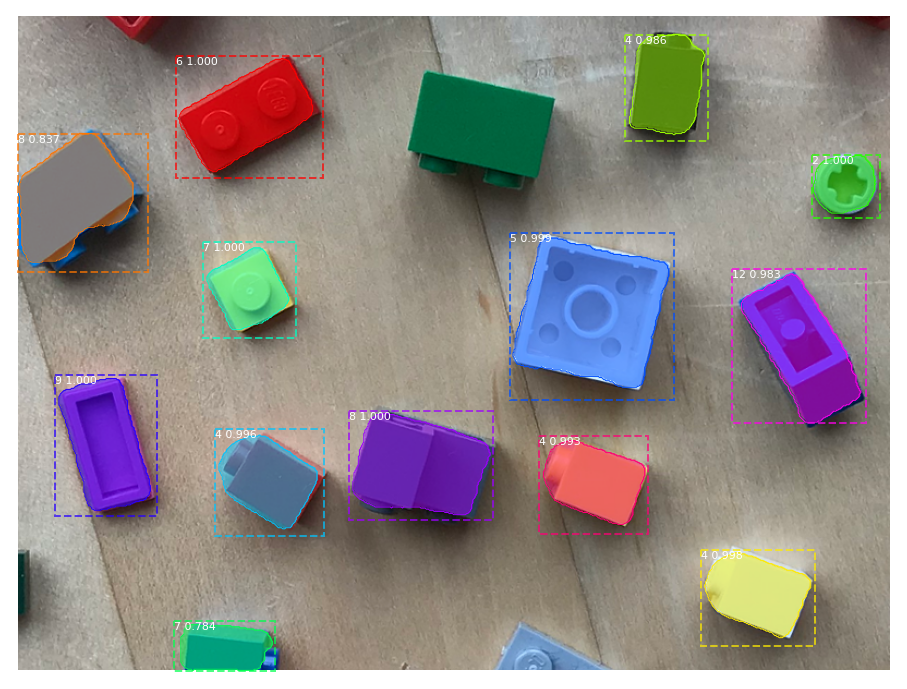

<Figure size 432x288 with 0 Axes>

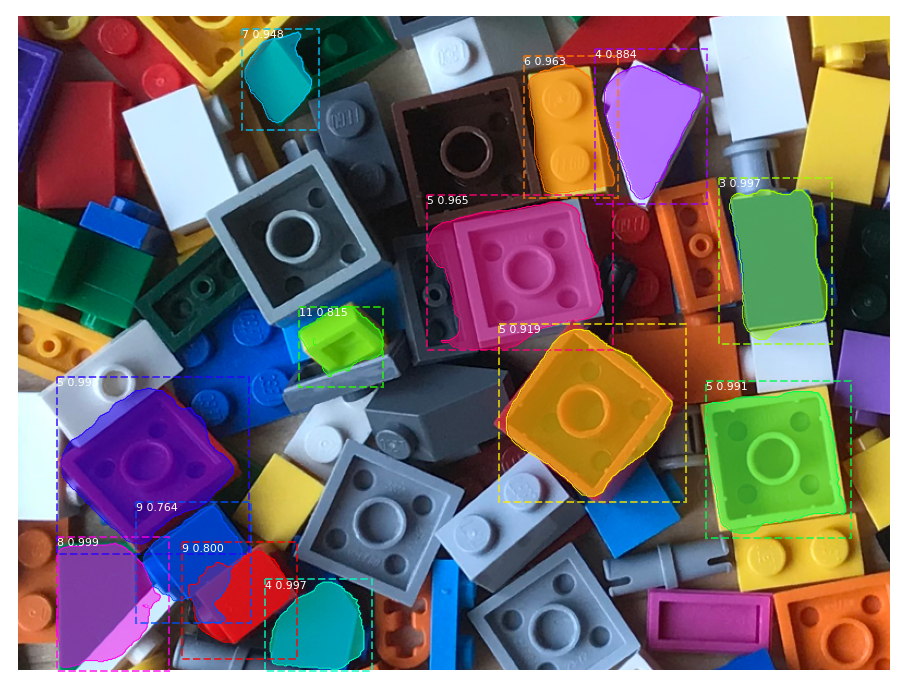

<Figure size 432x288 with 0 Axes>

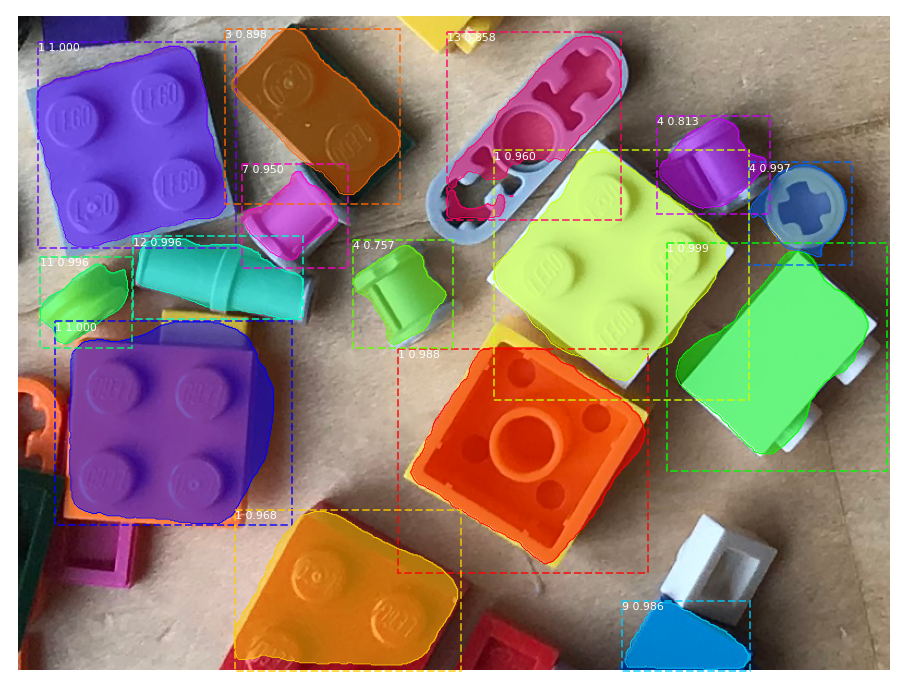

<Figure size 432x288 with 0 Axes>

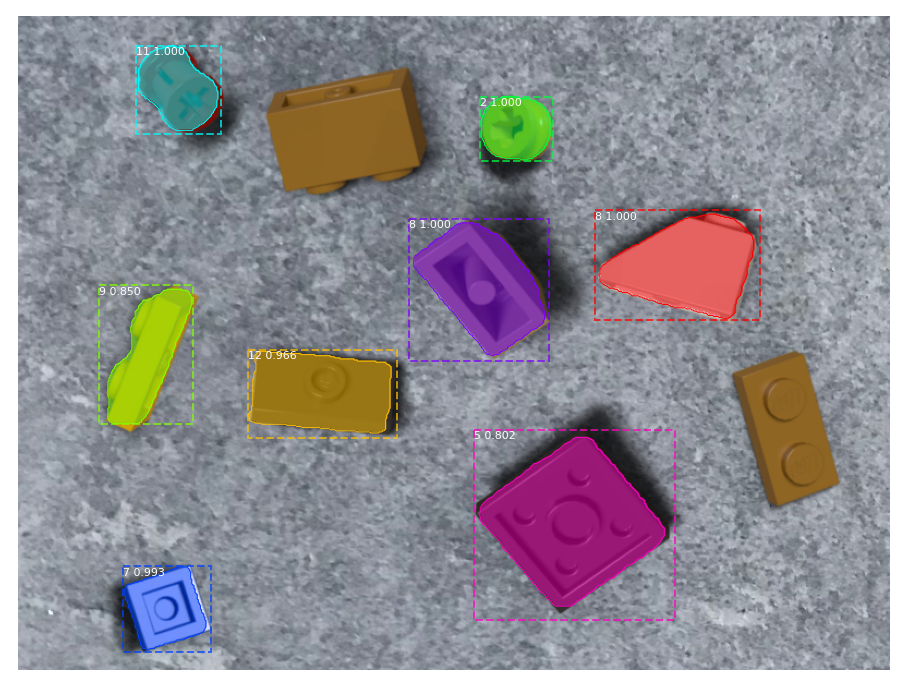

<Figure size 432x288 with 0 Axes>

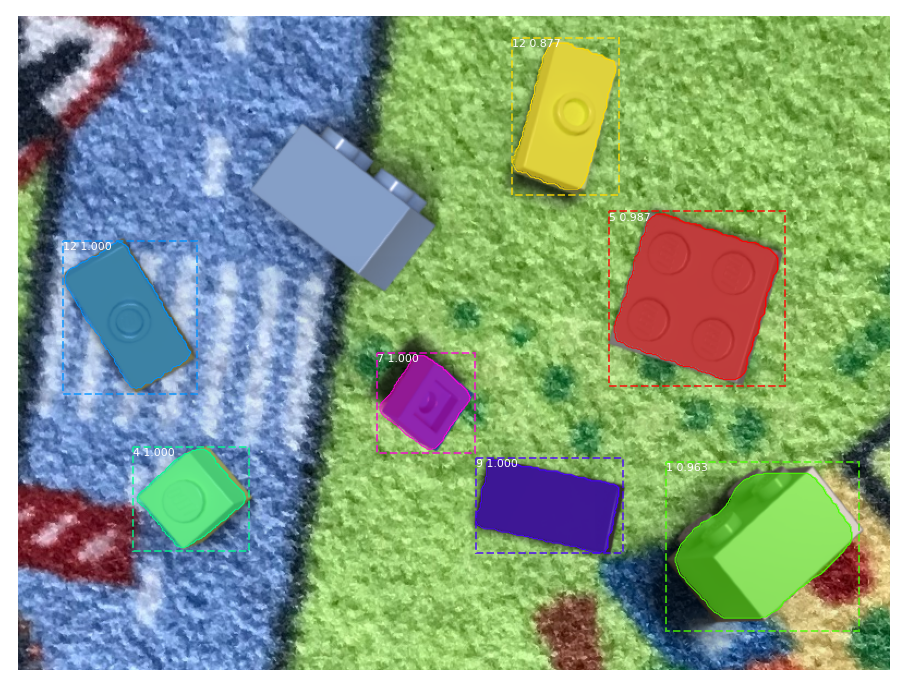

<Figure size 432x288 with 0 Axes>

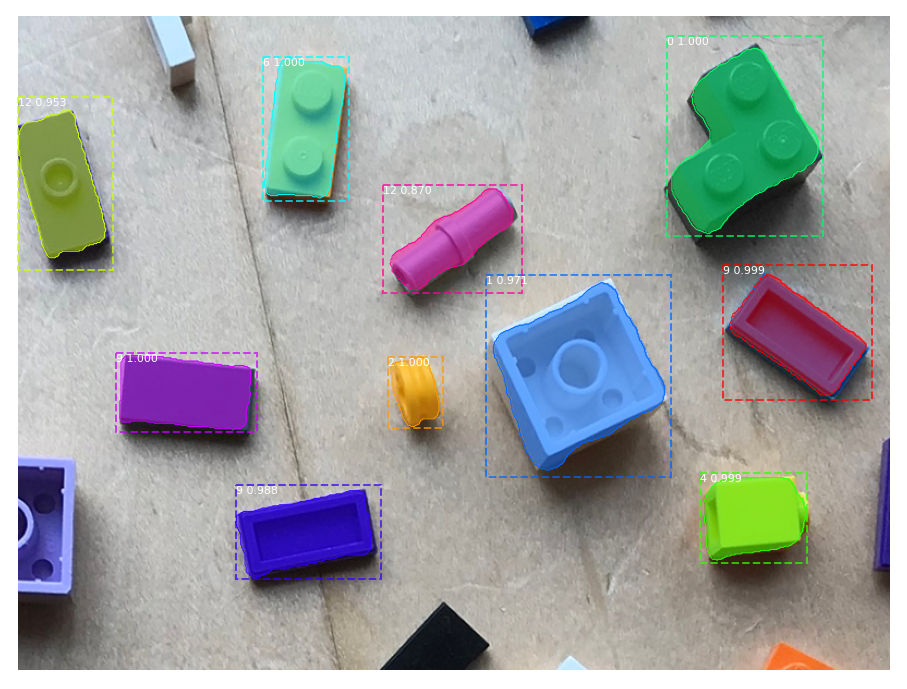

<Figure size 432x288 with 0 Axes>

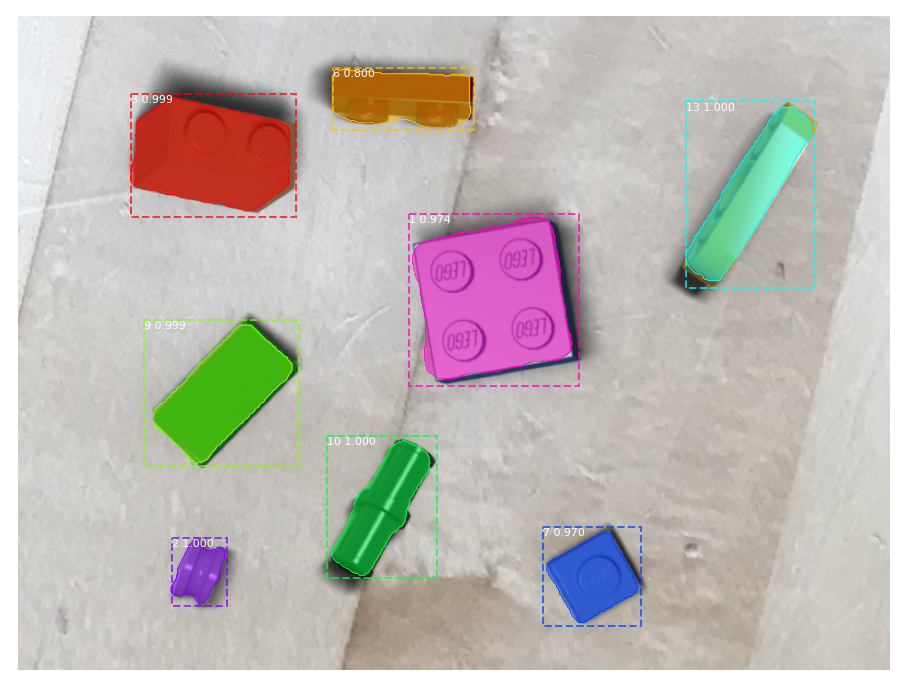

In [6]:
class_names = ['BG', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13']

for image_name in test_images:
    image = cv2.imread(os.path.join(test_images_path, image_name))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    results = model.detect([image], verbose=0)
    r = results[0]

    plt.figure()
    ax = get_ax(1)
#     visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'], ax=ax, title="Predictions")
    visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'], ax=ax)
    plt.savefig(f'test_{image_name}.png', bbox_inches='tight', pad_inches=-0.5, orientation='landscape')

In [ ]:
import samples.lego.lego
import mrcnn.model
import mrcnn.utils
import mrcnn.config
import os, sys

# If you change code on the fly, reload modules
import imp
imp.reload(mrcnn.config)
imp.reload(samples.lego.lego)
imp.reload(mrcnn.model)
imp.reload(mrcnn.utils)

from samples.lego.lego import main as tmain

# Configuration section
PATH_DATASET                = os.path.join('datasets', 'lego')
USE_PREV_WEIGHTS            = False # Set to True if you want to restart from a previous session
NB_OF_EPOCHS                = 45 # Typically 40 epoches are sufficient for this project, 

# Where are we
print('Script running in: ' + os.getcwd())
print("Python version: " + sys.version)
print("Python install path: " + sys.executable)

# Show tool version
import tensorflow
print(tensorflow.__version__)
# import keras
# print(keras.__version__)


# Call train function
if USE_PREV_WEIGHTS:
    LEGO_WEIGHTS_PATH = tmain([ 'train', '--dataset=' + PATH_DATASET, '--logs=snapshots', '--enable-augmentation', '--weights=last','--epochs=' + str(NB_OF_EPOCHS)])
else:
    LEGO_WEIGHTS_PATH = tmain([ 'train', '--dataset=' + PATH_DATASET, '--logs=snapshots','--enable-augmentation', '--epochs=' + str(NB_OF_EPOCHS)])

Script running in: /home/panda/ldm/Lego-CNN
Python version: 3.9.7 (default, Sep 16 2021, 13:09:58) 
[GCC 7.5.0]
Python install path: /home/panda/.conda/envs/lego/bin/python
2.5.0
Weights:  None
Dataset:  datasets/lego
Logs:  snapshots

Configurations:
BACKBONE                       resnet101
BACKBONE_FITLERS_CONFIG        {'S2': [64, 64], 'S3': [128, 128], 'S4': [256, 256], 'S5': [512, 512]}
BACKBONE_MRCNN                 resnet18
BACKBONE_RESNET_BASIC_DEFAULT  {'S2': [64, 64], 'S3': [128, 128], 'S4': [256, 256], 'S5': [512, 512]}
BACKBONE_RESNET_BASIC_WIDER    {'S2': [160, 160], 'S3': [320, 320], 'S4': [640, 640], 'S5': [1280, 1280]}
BACKBONE_RESNET_BOTTLE_DEFAULT {'S2': [64, 64, 256], 'S3': [128, 128, 512], 'S4': [256, 256, 1024], 'S5': [512, 512, 2048]}
BACKBONE_RESNET_BOTTLE_WIDER   {'S2': [256, 256, 256], 'S3': [512, 512, 512], 'S4': [1024, 1024, 1024], 'S5': [1024, 1024, 2048]}
BACKBONE_RPN                   resnet18
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE   